# Análisis del dataset: Longitud de texto, cantidad de caracteres, duración de audios promedio


In [1]:
import pandas as pd
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro, normaltest, kruskal, spearmanr
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
#Visualize the data
subjective_results = pd.read_csv('subjective_results_corrected.csv')
subjective_results.head()

,participant_id,age,gender_participant,country,province,education,headphone_brand,stimuli,score,stimuli_group,stimuli_service,gender_stimuli,dialect,mos_pred,model
0,ymxfxn696we9rp1tnnub3f,26,P,AR,Buenos Aires,5,samsung,/home/udesa_ubuntu/tesis/frontend/public/asset...,5.0,E2,open_srl_es_ar_female_2,F,ARG,4.201412,NISQA_TTS_v1
1,ymxfxn696we9rp1tnnub3f,26,P,AR,Buenos Aires,5,samsung,/home/udesa_ubuntu/tesis/frontend/public/asset...,5.0,E2,open_srl_es_ar_female_2,F,ARG,4.755947,NISQA_TTS_v1
2,9fig36z1cml41m265ckifw,25,M,AR,Buenos Aires,4,Sony,/home/udesa_ubuntu/tesis/frontend/public/asset...,5.0,E2,open_srl_es_ar_female_2,F,ARG,4.338622,NISQA_TTS_v1
3,vj735xlt2yj805wyn5rimq,59,F,AR,Buenos Aires,2,NaN,/home/udesa_ubuntu/tesis/frontend/public/asset...,4.0,E2,open_srl_es_ar_female_2,F,ARG,4.223487,NISQA_TTS_v1
4,vj735xlt2yj805wyn5rimq,59,F,AR,Buenos Aires,2,NaN,/home/udesa_ubuntu/tesis/frontend/public/asset...,4.0,E2,open_srl_es_ar_female_2,F,ARG,3.404321,NISQA_TTS_v1


In [3]:
# get stimuli column
stimuli = subjective_results['stimuli']

audio_lengths = []
for audio_path in stimuli:
    # extract the length of the audio file
    audio, sr = sf.read(audio_path)
    audio_lengths.append(len(audio)/sr)

# mean and standard deviation of audio lengths
mean_audio_length = np.mean(audio_lengths)
std_audio_length = np.std(audio_lengths)

print('Amount of audios rated: ', len(audio_lengths))
print('Mean audio length:', mean_audio_length)
print('Standard deviation of audio length:', std_audio_length)
print('Minimum audio length:', np.min(audio_lengths))
print('Maximum audio length:', np.max(audio_lengths))

Amount of audios rated:  4326
Mean audio length: 3.48849683803923
Standard deviation of audio length: 1.5410198567394044
Minimum audio length: 0.9288020833333334
Maximum audio length: 13.497010416666667


In [4]:
# print the spoken phrases in the audios
script = pd.read_csv('script.csv')
script.head()

,transcript
0,"Para la caída del cabello, tengo un nuevo jabón"
1,¿Qué color favorito es el más popular?
2,El pijama de rayas es azul
3,Las máquinas de escribir antiguas pueden ser m...
4,Al circular menos automóviles en la ciudad se ...


In [5]:
# Calculate word count for each phrase
script['word_count'] = script['transcript'].apply(lambda x: len(x.split()))

# Calculate character count for each phrase
script['char_count'] = script['transcript'].apply(lambda x: len(x))

# Calculate statistics
average_word_count = script['word_count'].mean()
average_char_count = script['char_count'].mean()
std_dev_word_count = script['word_count'].std()
std_dev_char_count = script['char_count'].std()
max_word_count = script['word_count'].max()
min_word_count = script['word_count'].min()
max_char_count = script['char_count'].max()
min_char_count = script['char_count'].min()
total_phrases = len(script)

# Output results
print("Average word count:", average_word_count)
print("Average character count:", average_char_count)
print("Standard deviation of word count:", std_dev_word_count)
print("Standard deviation of character count:", std_dev_char_count)
print("Maximum word count:", max_word_count)
print("Minimum word count:", min_word_count)
print("Maximum character count:", max_char_count)
print("Minimum character count:", min_char_count)
print("Total phrases:", total_phrases)

Average word count: 9.27
Average character count: 51.85
Standard deviation of word count: 4.019786918318789
Standard deviation of character count: 22.19763159629532
Maximum word count: 20
Minimum word count: 3
Maximum character count: 112
Minimum character count: 16
Total phrases: 100


## Descripción de los estimulos:

In [6]:
# gender_stiumuli distribution, grouped by stimuli_service
gender_stimuli_distribution = subjective_results.groupby(["stimuli_service", "gender_stimuli"])["stimuli"].count()

# count amount of F and M in gender_stimuli_distribution
gender_stimuli_count = gender_stimuli_distribution.groupby('gender_stimuli').size()
print(gender_stimuli_count)


gender_stimuli
F    27
M    26
Name: stimuli, dtype: int64


In [7]:
# dialects distribution, just count unique stimuli_service

dialects_distribution = subjective_results.groupby("stimuli_service")["dialect"].first().value_counts()
print(dialects_distribution)

dialect
ARG      23
ES        9
ES-US     7
CAST      5
MEX       5
BO        3
-         1
Name: count, dtype: int64


# Descripción del dataset: Resultados de la encuesta subjetiva

4327 pares de audios únicos, acompañados por una calificación de naturalidad del habla, en una escala tipo likert del 1 al 5.
+ Los audios provienen de ~50 sistemas distintos, en su gran mayoría, sistemas de TTS.
+ Los sistemas tienen distintos dialectos y generos de hablante
+ Los participantes, completaron una encuesta sociodemográfica, que incluye información sobre su edad, género, nivel de familiaridad con las voces sintetizadas, país/provincia de residencia, idioma nativo, y si tienen alguna discapacidad auditiva.
+ Cada participante evaluó, en promedio, 40 audios, cada uno de un sistema distinto.

# Análisis exploratorio de datos:

Se comienza cargando los datos, las columnas se corresponden con las distintas variables que se mencionaron en la descripción del dataset.

+ **participant_id**: identificador del participante
+ **age**: edad del participante
+ **gender_participant**: género del participante
+ **country**: país de residencia del participante
+ **province**: provincia de residencia del participante
+ **education**: nivel de familiaridad con voces sintetizadas del participante
+ **headphone_brand**: marca de auriculares utilizada por el participante
+ **stimuli**: identificador del audio
+ **score**: calificación de naturalidad del habla
+ **stimuli_group**: sistema utilizado para generar el audio (nombre corto)
+ **stimuli_service**: sistema utilizado para generar el audio (nombre largo)
+ **dialect**: dialecto de voz del estimulo
+ **mos_pred**: predicción de la naturalidad del audio realizada por NISQA_TTS_v1

In [8]:
subjective_results.head()

,participant_id,age,gender_participant,country,province,education,headphone_brand,stimuli,score,stimuli_group,stimuli_service,gender_stimuli,dialect,mos_pred,model
0,ymxfxn696we9rp1tnnub3f,26,P,AR,Buenos Aires,5,samsung,/home/udesa_ubuntu/tesis/frontend/public/asset...,5.0,E2,open_srl_es_ar_female_2,F,ARG,4.201412,NISQA_TTS_v1
1,ymxfxn696we9rp1tnnub3f,26,P,AR,Buenos Aires,5,samsung,/home/udesa_ubuntu/tesis/frontend/public/asset...,5.0,E2,open_srl_es_ar_female_2,F,ARG,4.755947,NISQA_TTS_v1
2,9fig36z1cml41m265ckifw,25,M,AR,Buenos Aires,4,Sony,/home/udesa_ubuntu/tesis/frontend/public/asset...,5.0,E2,open_srl_es_ar_female_2,F,ARG,4.338622,NISQA_TTS_v1
3,vj735xlt2yj805wyn5rimq,59,F,AR,Buenos Aires,2,NaN,/home/udesa_ubuntu/tesis/frontend/public/asset...,4.0,E2,open_srl_es_ar_female_2,F,ARG,4.223487,NISQA_TTS_v1
4,vj735xlt2yj805wyn5rimq,59,F,AR,Buenos Aires,2,NaN,/home/udesa_ubuntu/tesis/frontend/public/asset...,4.0,E2,open_srl_es_ar_female_2,F,ARG,3.404321,NISQA_TTS_v1


### Se calculan la distribución de los datos sociodemograficos de los participantes:

In [9]:
# compute the amount of unique participant_id in the participant_id column
unique_participant_id = subjective_results['participant_id'].nunique()
print('The amount of unique participant_id is:', unique_participant_id)

The amount of unique participant_id is: 92


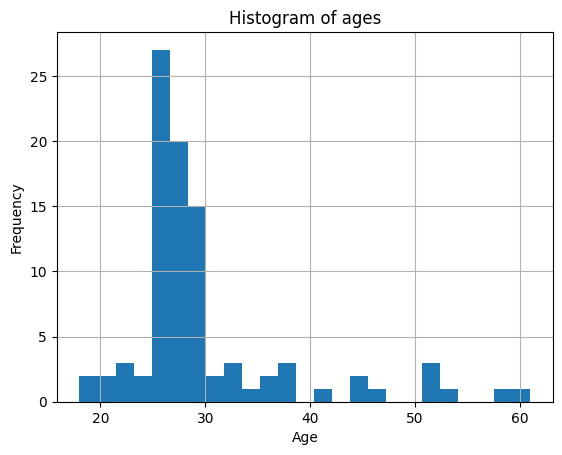

Average age:  29.945652173913043
Standard deviation of age:  8.246696482028335
Median age:  27.0
Minimum age:  18.0
Maximum age:  61.0


In [10]:
# subjective_results["age"] average and histogram
# just count the ages of unique participants, not all the rows
participant_ages = subjective_results.groupby("participant_id")["age"].mean()
participant_ages = participant_ages.dropna()


plt.hist(participant_ages, bins='auto')
plt.grid(True)
plt.title('Histogram of ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

print("Average age: ", participant_ages.mean())
print("Standard deviation of age: ", participant_ages.std())
print("Median age: ", participant_ages.median())
print("Minimum age: ", participant_ages.min())
print("Maximum age: ", participant_ages.max())

In [11]:
participant_ages.describe()

count    92.000000
mean     29.945652
std       8.246696
min      18.000000
25%      26.000000
50%      27.000000
75%      30.000000
max      61.000000
Name: age, dtype: float64

In [12]:
# gender distribution. Just count the gender of unique participants, not all the rows

gender_distribution = subjective_results.groupby("participant_id")["gender_participant"].first().value_counts()
print(gender_distribution)

gender_participant
M    64
F    25
X     2
P     1
Name: count, dtype: int64


In [13]:
# province distribution. Just count the provinces of unique participants, not all the rows

province_distribution = subjective_results.groupby("participant_id")["province"].first().value_counts()
print(province_distribution)

province
Buenos Aires                       41
Ciudad Autónoma de Buenos Aires    37
Río Negro                           2
Chubut                              2
Tierra del Fuego                    1
Chaco                               1
Neuqu�n                             1
Jujuy                               1
Misiones                            1
Neuquén                             1
La Pampa                            1
Name: count, dtype: int64


In [14]:
# education distribution. Just count the education of unique participants, not all the rows

education_distribution = subjective_results.groupby("participant_id")["education"].first().value_counts()
#print, ordering by education level
print(education_distribution.sort_index())

average_eduaction = subjective_results.groupby("participant_id")["education"].first().mean()
print("Average education: ", average_eduaction)
print("Standard deviation of education: ", subjective_results.groupby("participant_id")["education"].first().std())

education
1    12
2    26
3    21
4    17
5    16
Name: count, dtype: int64
Average education:  2.989130434782609
Standard deviation of education:  1.30505833491269


### Distribución de los scores de naturalidad del habla:

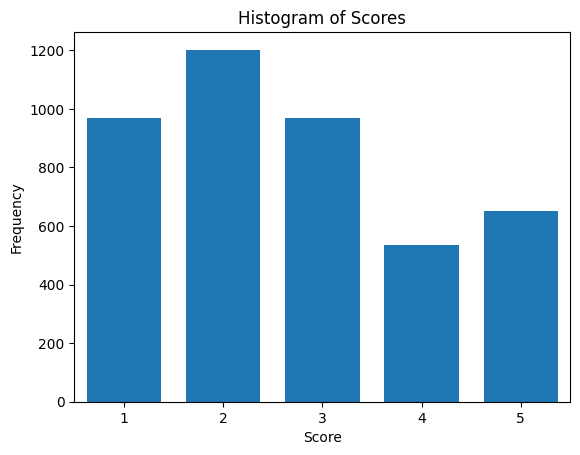

Shapiro-Wilk Test: Statistics=0.885, p=0.000
D’Agostino’s K^2 Test: Statistics=1136.162, p=0.000
Sample does not look Gaussian (reject H0) - Shapiro-Wilk Test
Sample does not look Gaussian (reject H0) - D’Agostino’s K^2 Test


In [15]:
# Extract scores
scores = subjective_results['score']

# Visual Inspection
plt.hist(scores, bins='auto')
plt.title('Histogram of Scores')
# set x-axis label 1-5
plt.xlabel('Score')
# set y-axis label
plt.ylabel('Frequency')
# set x ticks 1-5
plt.xticks(np.arange(1, 6, 1))
# set width of bars
plt.xlim(0.5, 5.5)
# set width of histogram bars to 1.5
plt.bar(np.arange(1, 6, 1), np.histogram(scores, bins=5)[0], width=0.75 )

plt.show()

# Statistical Tests
# Shapiro-Wilk Test
stat, p_shapiro = shapiro(scores)
print('Shapiro-Wilk Test: Statistics=%.3f, p=%.3f' % (stat, p_shapiro))

# D’Agostino’s K^2 Test
stat, p_dagostino = normaltest(scores)
print('D’Agostino’s K^2 Test: Statistics=%.3f, p=%.3f' % (stat, p_dagostino))

# Step 6: Interpretation
alpha = 0.05
if p_shapiro > alpha:
    print('Sample looks Gaussian (fail to reject H0) - Shapiro-Wilk Test')
else:
    print('Sample does not look Gaussian (reject H0) - Shapiro-Wilk Test')

if p_dagostino > alpha:
    print('Sample looks Gaussian (fail to reject H0) - D’Agostino’s K^2 Test')
else:
    print('Sample does not look Gaussian (reject H0) - D’Agostino’s K^2 Test')

### Agrupación de los estimulos por sistema y calculo de estadisticos descriptivos:

In [16]:
# Group by "stimuli_service" and calculate the statistics
scores_by_system = subjective_results.groupby("stimuli_service")["score"].describe()[["mean", "std", "25%", "50%", "75%"]]

# Print the statistics
print(scores_by_system)


                              mean       std   25%  50%   75%
stimuli_service                                              
DC_TTS_Camila_Godoy       1.890756  1.015055  1.00  2.0  2.50
DC_TTS_Celeste_Arretche   2.388889  1.166778  2.00  2.0  3.00
DC_TTS_LucasDiaz          2.610526  1.222961  2.00  2.0  3.50
DC_TTS_MaxSignorini       2.818182  1.167748  2.00  3.0  3.50
DC_TTS_Miguel_Grassi      2.000000  1.264911  1.00  1.5  2.75
DC_TTS_NaomiBent          1.938776  1.110552  1.00  2.0  2.00
DC_TTS_SanMig             1.700000  1.251666  1.00  1.0  2.00
Fastpitch_MultiSpeaker    1.762376  1.147340  1.00  1.0  2.00
Fastpitch_ar              2.721212  0.997484  2.00  3.0  3.00
Fastpitch_esp             2.551515  0.920008  2.00  2.0  3.00
Fastpitch_esp2            2.769697  0.928047  2.00  3.0  3.00
Loquendo_f                1.744898  0.722413  1.00  2.0  2.00
PollyN_Fiona              2.532609  0.857431  2.00  3.0  3.00
PollyN_Pedro              2.781609  1.050197  2.00  3.0  3.50
Polly_En

### Puntaje vs grupo de estímulos ordenados por puntaje medio

/tmp/ipykernel_22901/2449238003.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores_by_system_sorted.index, y=scores_by_system_sorted["mean"], palette="viridis")


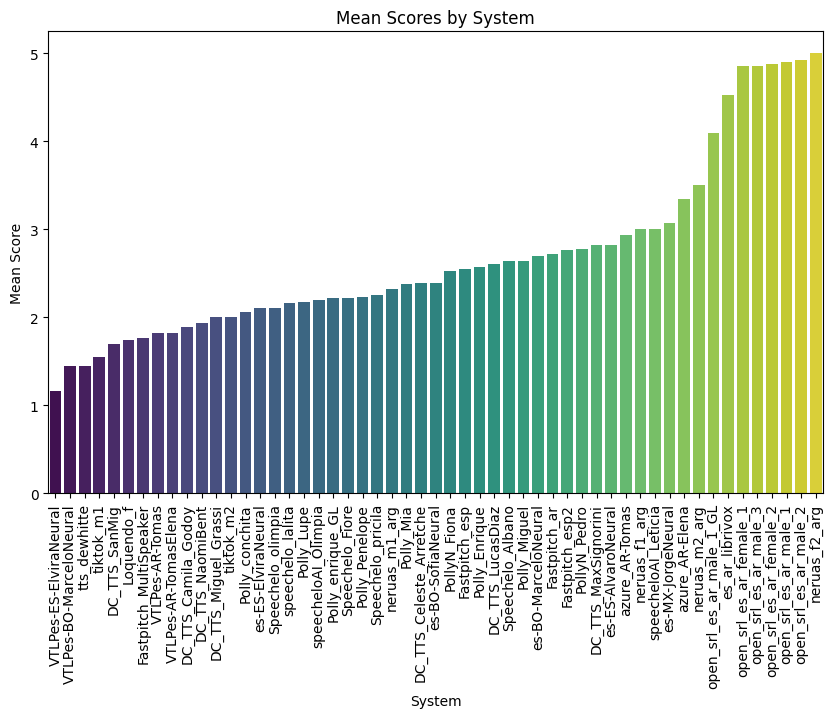

In [33]:
# sort scores_by_system by "mean" in descending order
scores_by_system_sorted = scores_by_system.sort_values(by="mean", ascending=True)

# plot scores_by_system_sorted["mean"] using seaborn

plt.figure(figsize=(10, 6))
sns.barplot(x=scores_by_system_sorted.index, y=scores_by_system_sorted["mean"], palette="viridis")
plt.title("Mean Scores by System")
plt.xlabel("System")
plt.ylabel("Mean Score")
plt.xticks(rotation=90)
plt.show() 

In [48]:
#drop std, 25%, 50%, 75% columns
scores_by_system_sorted = scores_by_system_sorted.drop(columns=["std", "25%", "50%", "75%"])
scores_by_system_sorted

,mean
stimuli_service,
VTLPes-ES-ElviraNeural,1.166667
VTLPes-BO-MarceloNeural,1.449438
tts_dewhitte,1.452830
tiktok_m1,1.555556
DC_TTS_SanMig,1.700000
Loquendo_f,1.744898
Fastpitch_MultiSpeaker,1.762376
VTLPes-AR-Tomas,1.825397
VTLPes-AR-TomasElena,1.825397


# Boxplot

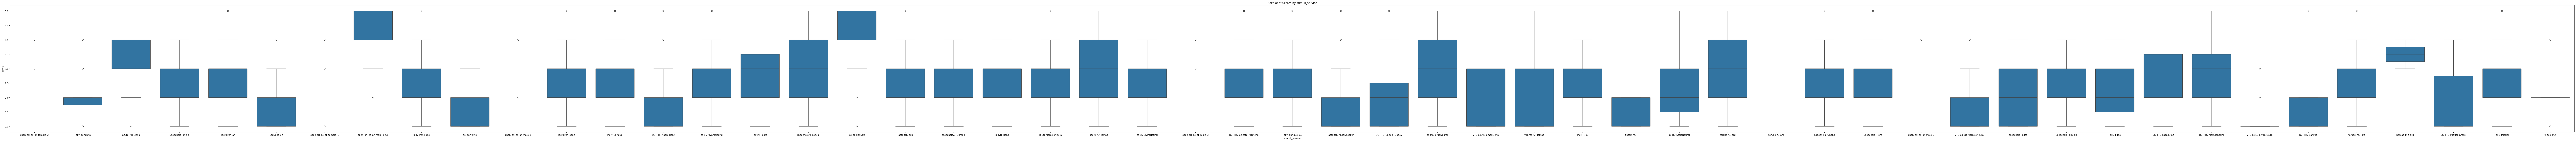

In [17]:
# boxplot of scores by age, gender, education, province, dialect, gender_stimuli
# Boxplot of scores by gender
# plt.boxplot([subjective_results[subjective_results['gender_participant'] == "F"]['score'],
#              subjective_results[subjective_results['gender_participant'] == "M"]['score']],
#             labels=['Female', 'Male'])

# plt.title('Boxplot of Scores by Gender')
# plt.xlabel('Gender')
# plt.ylabel('Score')
# plt.show()
# # boxplot of scores by education
# plt.boxplot([subjective_results[subjective_results['education'] == 1]['score'],
#              subjective_results[subjective_results['education'] == 2]['score'],
#              subjective_results[subjective_results['education'] == 3]['score'],
#              subjective_results[subjective_results['education'] == 4]['score'],
#              subjective_results[subjective_results['education'] == 5]['score']],
#             labels=['nada familiar', 'poco familiar', 'algo familiar',"familiar","muy familiar"])

# boxplot of scores by stimuli_service
plt.figure(figsize=(200, 10))
sns.boxplot(x='stimuli_service', y='score', data=subjective_results)
plt.title('Boxplot of Scores by stimuli_service')
plt.xlabel('stimuli_service')
plt.ylabel('Score')
plt.show()

# Kruskall-Wallis

In [37]:
# Assuming the CSV data is loaded into a DataFrame named df
# Prepare the data for analysis
groups = subjective_results.groupby("stimuli_service")["score"].apply(list).to_dict()

# Perform the Kruskal-Wallis test
# Unpack the group scores into the kruskal function
stat, p = kruskal(*groups.values())

print(f'Statistic: {stat}, p-value: {p}')

# Interpret the p-value
alpha = 0.05  # significance level
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')


Statistic: 2105.9834593587175, p-value: 0.0
Different distributions (reject H0)


In [19]:
import scikit_posthocs as sp
# Conducting Dunn's test for pairwise comparisons after Kruskal-Wallis test
# First, perform Kruskal-Wallis if not already done to ensure there's a significant difference
# Here, we proceed directly to Dunn's test assuming significant Kruskal-Wallis result

# Dunn's test using 'scikit-posthocs'
# 'p_adjust' method can be 'bonferroni', 'holm', 'fdr_bh', etc. for adjusting p-values for multiple comparisons
dunn_result = sp.posthoc_dunn(subjective_results, val_col='score', group_col='stimuli_service', p_adjust='bonferroni')

print(dunn_result)

# save to csv
dunn_result.to_csv('dunn_result.csv')


                          DC_TTS_Camila_Godoy  DC_TTS_Celeste_Arretche  \
DC_TTS_Camila_Godoy              1.000000e+00             1.000000e+00   
DC_TTS_Celeste_Arretche          1.000000e+00             1.000000e+00   
DC_TTS_LucasDiaz                 5.203841e-02             1.000000e+00   
DC_TTS_MaxSignorini              1.000000e+00             1.000000e+00   
DC_TTS_Miguel_Grassi             1.000000e+00             1.000000e+00   
DC_TTS_NaomiBent                 1.000000e+00             1.000000e+00   
DC_TTS_SanMig                    1.000000e+00             1.000000e+00   
Fastpitch_MultiSpeaker           1.000000e+00             1.410765e-02   
Fastpitch_ar                     1.033993e-05             1.000000e+00   
Fastpitch_esp                    3.218720e-03             1.000000e+00   
Fastpitch_esp2                   9.933052e-07             1.000000e+00   
Loquendo_f                       1.000000e+00             4.858278e-01   
PollyN_Fiona                     4.073

# Spearman

In [54]:
# Assuming "stimuli_group" is the column representing the group each audio belongs to
# and "score" is the column representing the score given to each audio
group_scores = subjective_results.groupby('stimuli_group')['score'].mean()

# Assuming you want to use Spearman's rank correlation coefficient
correlation_coefficient, p_value = spearmanr(scores_by_system_sorted.index, scores_by_system_sorted.values)

print("Correlation coefficient:", correlation_coefficient)
print("p-value:", p_value)

Correlation coefficient: 0.2814289179378296
p-value: 0.04120685800302595


# Kruskal Wallis (de nuevo, tomando los scores promedios)

In [73]:
# Sample data
data = {
    "stimuli_group": group_scores.index,
    "rating": group_scores.values
}

# Creating a DataFrame
df = pd.DataFrame(data)

# Grouping the data by 'stimuli_group'
groups = df.groupby('stimuli_group')['rating'].apply(list).values

# Performing the Kruskal-Wallis H-test
stat, p_value = kruskal(*groups)

stat, p_value


(48.99999999999997, 0.47312829565476633)

### Kruskal-Wallis H-test conclusion
The Kruskal-Wallis H-test resulted in a statistic of approximately 49.00 and a p-value of 0.473. The p-value indicates that there is not enough evidence to reject the null hypothesis at common significance levels (e.g., α = 0.05). This suggests that there are no statistically significant differences between the median ratings of the various stimuli groups in your dataset. 

# Chi-square test

[memphis.edu](http://www.ce.memphis.edu/7012/L17_CategoricalVariableAssociation.pdf) 

[wikipedia](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)

#TODO test de pearson, chi cuadrado, ves si es indep el eje del grupo vs el eje del score (promedio?)
### Conclusion
Given your dataset involves a continuous rating scale (1 to 5) across different stimuli groups, Pearson's Chi-squared test might not be the most appropriate choice. The Chi-squared test is typically used for categorical data to test the independence between two categorical variables. Your "rating" variable is continuous (or can be considered ordinal with more than 5 categories), not categorical in the traditional sense required for a Chi-squared test.


# Conclusiones iniciales del análisis exploratorio:

+ la distribución de los scores de naturalidad no sigue una distribución normal 
+ la mayoría de los participantes son de género masculino
+ la mayoría de los participantes tienen entre 25 y 30 años
+ ~fuerte correlación positiva entre el grupo al que pertenece cada audio y su respectiva puntuación


# Regresión logística ordinal:

## Supuestos:
1. La variable dependiente está ordenada.
2. Una o más de las variables independientes son continuas, categóricas u ordinales.
3. No hay multicolinealidad.
4. Probabilidades proporcionales.

Los primeros dos supuestos se cumplen sin necesidad de realizar ninguna prueba.

In [21]:
subjective_results = pd.read_csv('subjective_results_corrected.csv')

In [22]:
# # Replace gender_participant values with corresponding numerical values
# # assign one encoding 
# subjective_results['gender_participant'].replace({'F': [1, 0, 0, 0], 'M': [0, 1, 0, 0], 'X': [0, 0, 1, 0], 'P': [0, 0, 0, 1]}, inplace=True)
# subjective_results['gender_stimuli'].replace({'F': [1, 0], 'M': [0, 1]}, inplace=True)
# #replace stimuli_group values with corresponding numerical values A1 = 0, A2 = 1... B1 = 10, B2 = 11... C1 = 20, C2 = 21
# subjective_results['stimuli_group'].replace({'A1': 0, 'A2': 1, 'A3': 2, 'A4': 3, 'A5': 4, 'A6': 5, 'A7': 6, 'A8': 7, 'A9': 8, 'A10': 9, 'B1': 10, 'B2': 11, 'B3': 12, 'B4': 13, 'B5': 14, 'B6': 15, 'B7': 16, 'B8': 17, 'B9': 18, 'B10': 19, 'C1': 20, 'C2': 21, 'C3': 22, 'C4': 23, 'C5': 24, 'C6': 25, 'C7': 26, 'C8': 27, 'C9': 28, 'C10': 29, 'D1': 30, 'D2': 31, 'D3': 32, 'D4': 33, 'D5': 34, 'D6': 35, 'D7': 36, 'D8': 37, 'D9': 38, 'D10': 39, 'E1': 40, 'E2': 41, 'E3': 42, 'E4': 43, 'E5': 44, 'E6': 45, 'E7': 46, 'E8': 47, 'E9': 48, 'E10': 49}, inplace=True)
# subjective_results['dialect'].replace({'ARG' : [1, 0, 0, 0, 0, 0, 0], 'ES': [0, 1, 0, 0, 0, 0, 0], 'ES-US': [0, 0, 1, 0, 0, 0, 0], 'CAST': [0, 0, 0, 1, 0, 0, 0], 'MEX': [0, 0, 0, 0, 1, 0, 0], 'BO': [0, 0, 0, 0, 0, 1, 0], '-': [0, 0, 0, 0, 0, 0, 1]}, inplace=True)
# subjective_results.head()

In [23]:
# Label Encoding
# Replace gender_participant values with corresponding numerical values
subjective_results['gender_participant'].replace({'F': 0, 'M': 1, 'X': 2, 'P': 3}, inplace=True)
subjective_results['gender_stimuli'].replace({'F': 0, 'M': 1}, inplace=True)
#replace stimuli_group values with corresponding numerical values A1 = 0, A2 = 1... B1 = 10, B2 = 11... C1 = 20, C2 = 21
subjective_results['stimuli_group'].replace({'A1': 0, 'A2': 1, 'A3': 2, 'A4': 3, 'A5': 4, 'A6': 5, 'A7': 6, 'A8': 7, 'A9': 8, 'A10': 9, 'B1': 10, 'B2': 11, 'B3': 12, 'B4': 13, 'B5': 14, 'B6': 15, 'B7': 16, 'B8': 17, 'B9': 18, 'B10': 19, 'C1': 20, 'C2': 21, 'C3': 22, 'C4': 23, 'C5': 24, 'C6': 25, 'C7': 26, 'C8': 27, 'C9': 28, 'C10': 29, 'D1': 30, 'D2': 31, 'D3': 32, 'D4': 33, 'D5': 34, 'D6': 35, 'D7': 36, 'D8': 37, 'D9': 38, 'D10': 39, 'E1': 40, 'E2': 41, 'E3': 42, 'E4': 43, 'E5': 44, 'E6': 45, 'E7': 46, 'E8': 47, 'E9': 48, 'E10': 49}, inplace=True)
subjective_results['dialect'].replace({'ARG' : 0, 'ES': 1, 'ES-US': 2, 'CAST': 3, 'MEX': 4, 'BO': 5, '-': 6}, inplace=True)
subjective_results.head()



,participant_id,age,gender_participant,country,province,education,headphone_brand,stimuli,score,stimuli_group,stimuli_service,gender_stimuli,dialect,mos_pred,model
0,ymxfxn696we9rp1tnnub3f,26,3,AR,Buenos Aires,5,samsung,/home/udesa_ubuntu/tesis/frontend/public/asset...,5.0,41,open_srl_es_ar_female_2,0,0,4.201412,NISQA_TTS_v1
1,ymxfxn696we9rp1tnnub3f,26,3,AR,Buenos Aires,5,samsung,/home/udesa_ubuntu/tesis/frontend/public/asset...,5.0,41,open_srl_es_ar_female_2,0,0,4.755947,NISQA_TTS_v1
2,9fig36z1cml41m265ckifw,25,1,AR,Buenos Aires,4,Sony,/home/udesa_ubuntu/tesis/frontend/public/asset...,5.0,41,open_srl_es_ar_female_2,0,0,4.338622,NISQA_TTS_v1
3,vj735xlt2yj805wyn5rimq,59,0,AR,Buenos Aires,2,NaN,/home/udesa_ubuntu/tesis/frontend/public/asset...,4.0,41,open_srl_es_ar_female_2,0,0,4.223487,NISQA_TTS_v1
4,vj735xlt2yj805wyn5rimq,59,0,AR,Buenos Aires,2,NaN,/home/udesa_ubuntu/tesis/frontend/public/asset...,4.0,41,open_srl_es_ar_female_2,0,0,3.404321,NISQA_TTS_v1


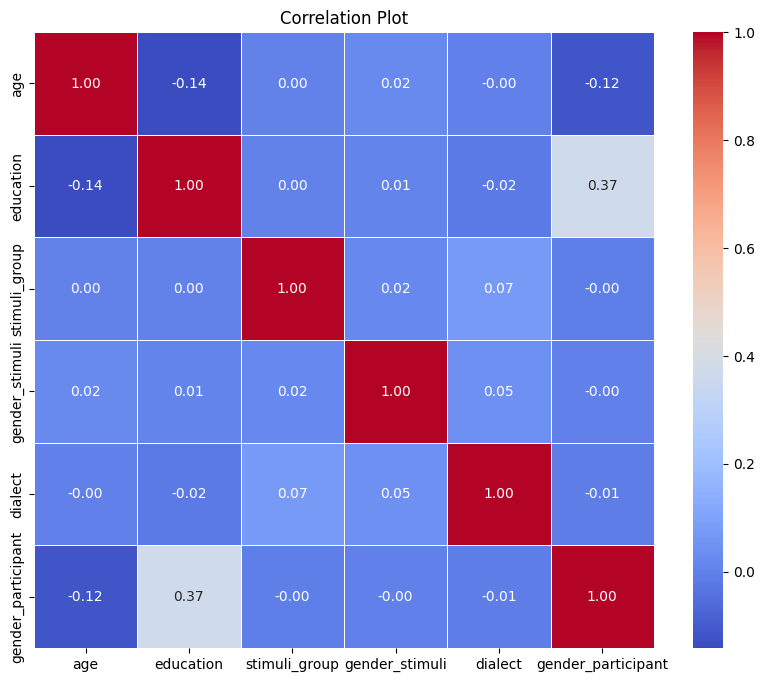

In [24]:
# Select relevant columns
selected_columns = ['age', 'education','stimuli_group', 'gender_stimuli','dialect', 'gender_participant']

# Create a subset dataframe with selected columns
subset_script = subjective_results[selected_columns]

# Convert categorical variables to numerical values if needed
# For example, you can use Label Encoding or One-Hot Encoding

# Calculate the correlation matrix
correlation_matrix = subset_script.corr()

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Plot')
plt.show()


### Utilizamos VIF para evaluar la multicolinealidad:

In [25]:
# Select relevant columns
selected_columns = ['age', 'gender_participant', 'education', 'stimuli_group', 'gender_stimuli', 'score', 'dialect']

# Create a subset dataframe with selected columns
subset_df = subjective_results[selected_columns]

# Convert categorical variables to numerical values if needed
# For example, you can use Label Encoding or One-Hot Encoding

# Calculate the VIF for each variable
vif_data = pd.DataFrame()
vif_data["Variable"] = subset_df.columns
vif_data["VIF"] = [variance_inflation_factor(subset_df.values, i) for i in range(subset_df.shape[1])]

# Display the VIF values
print(vif_data)


             Variable       VIF
0                 age  6.378189
1  gender_participant  3.408712
2           education  6.027721
3       stimuli_group  4.929271
4      gender_stimuli  1.866447
5               score  6.649178
6             dialect  1.849156


## Evaluar proporcionalidad de probabilidades con la prueba de Brant:

In [26]:
### COMPLETAR


## Regresión logística ordinal

dependent variable **SCORE** is categorical and ordered

## Hypothesis
Since the outcome variable is categorized and ranked, we can perform an Ordinal Logistic Regression analysis on the dataset. We set the alpha = 0.05 and the hypothesis as follows:

+ H0: there is no statistically significant factors between the variables that influence the Happiness Score
+ H1: there is at least one statistically significant factor between the variables that influence the Happiness Score

In [27]:
subjective_results = pd.read_csv('subjective_results_corrected.csv')
subjective_results.head()

,participant_id,age,gender_participant,country,province,education,headphone_brand,stimuli,score,stimuli_group,stimuli_service,gender_stimuli,dialect,mos_pred,model
0,ymxfxn696we9rp1tnnub3f,26,P,AR,Buenos Aires,5,samsung,/home/udesa_ubuntu/tesis/frontend/public/asset...,5.0,E2,open_srl_es_ar_female_2,F,ARG,4.201412,NISQA_TTS_v1
1,ymxfxn696we9rp1tnnub3f,26,P,AR,Buenos Aires,5,samsung,/home/udesa_ubuntu/tesis/frontend/public/asset...,5.0,E2,open_srl_es_ar_female_2,F,ARG,4.755947,NISQA_TTS_v1
2,9fig36z1cml41m265ckifw,25,M,AR,Buenos Aires,4,Sony,/home/udesa_ubuntu/tesis/frontend/public/asset...,5.0,E2,open_srl_es_ar_female_2,F,ARG,4.338622,NISQA_TTS_v1
3,vj735xlt2yj805wyn5rimq,59,F,AR,Buenos Aires,2,NaN,/home/udesa_ubuntu/tesis/frontend/public/asset...,4.0,E2,open_srl_es_ar_female_2,F,ARG,4.223487,NISQA_TTS_v1
4,vj735xlt2yj805wyn5rimq,59,F,AR,Buenos Aires,2,NaN,/home/udesa_ubuntu/tesis/frontend/public/asset...,4.0,E2,open_srl_es_ar_female_2,F,ARG,3.404321,NISQA_TTS_v1


In [28]:
subjective_results = pd.get_dummies(subjective_results, columns=['dialect'], prefix='dialect')
subjective_results = pd.get_dummies(subjective_results, columns=["gender_participant"], prefix='gender_participant')
subjective_results = pd.get_dummies(subjective_results, columns=["gender_stimuli"], prefix='gender_stimuli')
subjective_results.head()

,participant_id,age,country,province,education,headphone_brand,stimuli,score,stimuli_group,stimuli_service,...,dialect_CAST,dialect_ES,dialect_ES-US,dialect_MEX,gender_participant_F,gender_participant_M,gender_participant_P,gender_participant_X,gender_stimuli_F,gender_stimuli_M
0,ymxfxn696we9rp1tnnub3f,26,AR,Buenos Aires,5,samsung,/home/udesa_ubuntu/tesis/frontend/public/asset...,5.0,E2,open_srl_es_ar_female_2,...,False,False,False,False,False,False,True,False,True,False
1,ymxfxn696we9rp1tnnub3f,26,AR,Buenos Aires,5,samsung,/home/udesa_ubuntu/tesis/frontend/public/asset...,5.0,E2,open_srl_es_ar_female_2,...,False,False,False,False,False,False,True,False,True,False
2,9fig36z1cml41m265ckifw,25,AR,Buenos Aires,4,Sony,/home/udesa_ubuntu/tesis/frontend/public/asset...,5.0,E2,open_srl_es_ar_female_2,...,False,False,False,False,False,True,False,False,True,False
3,vj735xlt2yj805wyn5rimq,59,AR,Buenos Aires,2,NaN,/home/udesa_ubuntu/tesis/frontend/public/asset...,4.0,E2,open_srl_es_ar_female_2,...,False,False,False,False,True,False,False,False,True,False
4,vj735xlt2yj805wyn5rimq,59,AR,Buenos Aires,2,NaN,/home/udesa_ubuntu/tesis/frontend/public/asset...,4.0,E2,open_srl_es_ar_female_2,...,False,False,False,False,True,False,False,False,True,False
